## 47. 미니 프로젝트: ARIMA, ARCH


### ① 데이터 연결하기

-  데이터가 있는 폴더를 연결.arch를 설치.

In [1]:
!mkdir -p aiffel/time_series_basic 
#!ln -s data/* aiffel/time_series_basic
!cp data/AirPassengers.csv aiffel/time_series_basic/

cp: cannot stat 'data/AirPassengers.csv': No such file or directory


In [4]:
!pip install arch # Pip Installs Packages의 약자. Python 패키지를 설치하고 관리하는 Package Manneger.

### ② ARIMA 실습!

- AirPassengers 데이터셋을 SARIMA를 통해 예측.

- 시계열 데이터 분석을 위한 해당 라이브러리들과 AirPassengers 데이터셋을 불러옴.

- statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석등의 기능을 파이썬에서도 이용할 수 있도록 하는 통계 패키지.

- AirPassengers 데이터셋의 Month column을 제외.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA #아리마 모델
import pmdarima as pm #오토 아리마

In [6]:
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')
ap.drop('Month', axis = 1, inplace = True) #  drop등의 메서드를 사용할때, 변경값(변경될 데이터 프레임)을 저장할때 사용 inplace = True (저장함)

### ③ 데이터 확인하기

AirPassengers 데이터셋에서 Month가 제대로 제외되었는지 확인

In [7]:
ap # 윗중에 정의해놔 ap만 치면 확인됨.

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


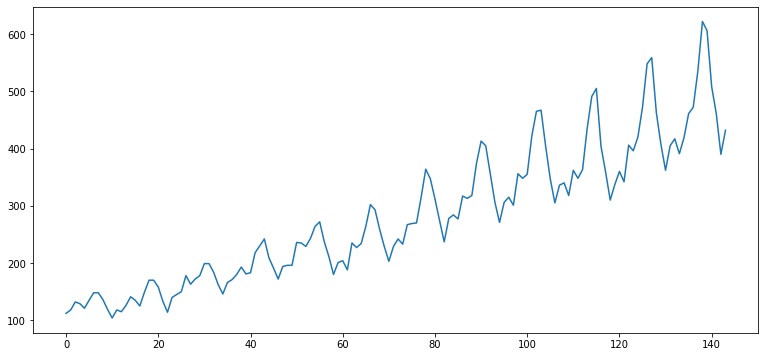

In [14]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ap)
plt.show() # 산점도등 그래프 종류 안쓰면 아래 기본적 그래프 나옴. 

### ④ 분산을 일정하게 만들기 - log transformation

- Log Transformation로그변환을 통해 아래경우들에 분산을 일정하게 조절.
 
    1.시간흐름에 비례하여 값이 커지는 경우(분산 증가)
  
  2. 비정상 확률 과정으로 표준편차가 자료의 크기에 비례하여 증가하거나 지수함수적으로 증가하는 경우
  
  3. 로그 변환한 확률 과정의 분산은 일정하기에 추세 제거로 기댓값이 0이 되면 정상 과정으로 모형화 가능


- 분산이 일정하게 적용되었는지 시각화한 후 확인.

In [15]:
ap_transformed = np.log(ap)# np.log를 통해서 log transformation

In [16]:
ap_transformed # 위에 112등에서 로그변환하고 4.7등으로 바뀜.

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


[]

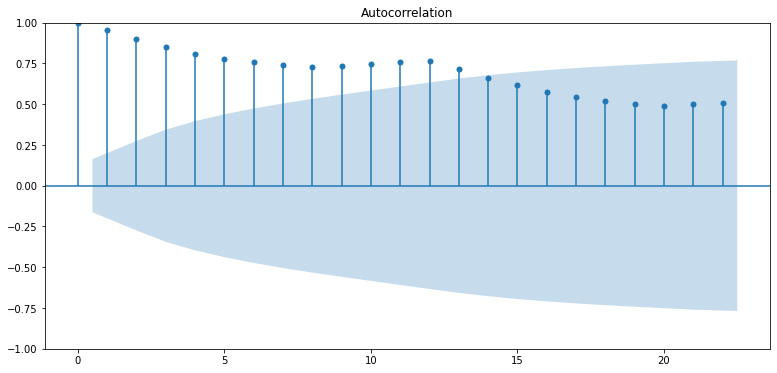

In [17]:
plot_acf(ap_transformed) #acf plot, 점차 감소하는 모양새를 지니고 있음
plt.rcParams["figure.figsize"] = (13,6) 
plt.plot() # 음영보다 값이 크면(음영 윗부분) 유의미.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

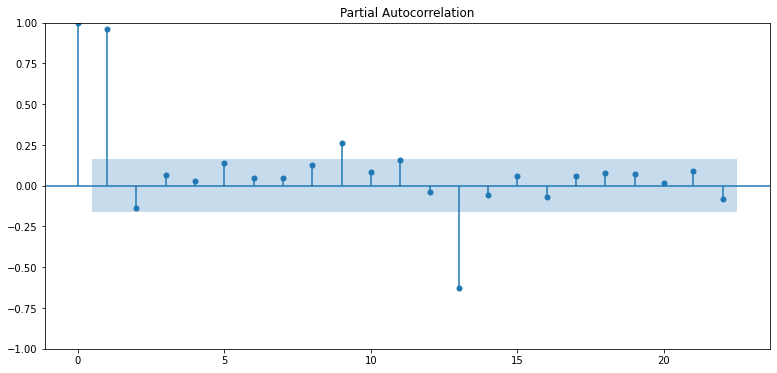

In [18]:
plot_pacf(ap_transformed) #pacf plot, lag 2까지 유의미한 결과를 보임
plt.rcParams["figure.figsize"] = (13,6) 
plt.plot() # 자기자신외 1, 12에서만 유의미.위 그래프에서 보듯 증가하는 추세를 가진 datae들은 ACF, PACF 그래프들이 이와 유사한 모양을 갖는다.

### ⑤ 차분을 통해 분석하기

ACF, PACF Plot과 차분을 통해 추세제거후 분석.

In [20]:
ap_diff = ap_transformed.diff() # 로그변환한걸 차분해서 ap_diff라고 명명.
ap_diff = ap_diff.dropna() 

[]

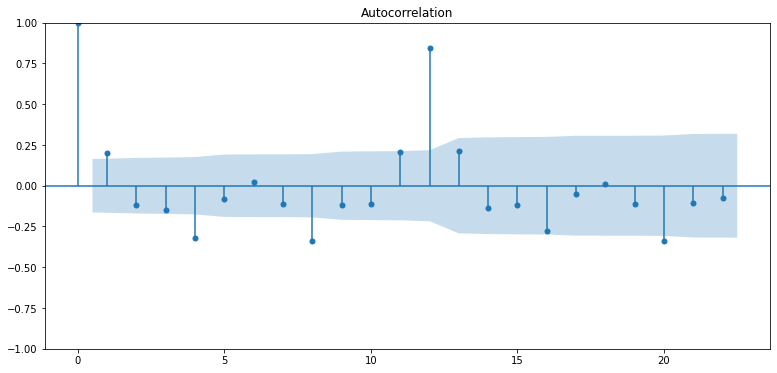

In [21]:
plot_acf(ap_diff) # lag 1과 lag 12에서 유의미한 lag가 포착됨
plt.plot()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

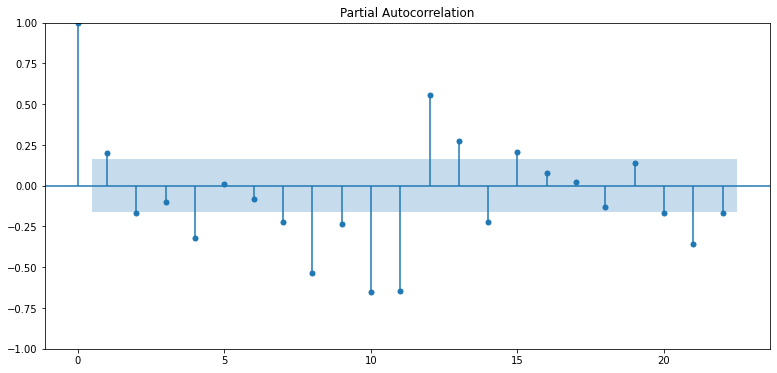

In [22]:
#lag 1, lag 8~12쯤에서 유의미한 lag가 포착됨
plot_pacf(ap_diff)
plt.plot()

-  n = 12가 유의미한 상관관계 나타난다. 이는 계절성 때문. SARIMA를 적용하겠군. Q PACF  n = 12가 유의미한 상관관계가 나타난다고 왜 계절성 때문인지? 

   SARIMA : ARIMA 모델에 계절성의 요소를 추가한 모델.
   계절(m)에 대한 AR(P), 차분(D), MA(Q)을 ARIMA 모델에 포함시킴으로써 계절성이 있는 데이터도 모델링.
   3:30 AutoARIMA를 접합을 할때 계절성을 고려하게 해줘야.

In [23]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


In [24]:
# test에 활용할 부분을 분리
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed [train_size:]

### ⑥ Auto ARIMA 적용 및 결과 확인

- AutoARIMA 내부 인자의 의미를 알아본다.
- seasonal : False인 경우 non-seasonal model로 제한.
- suppress_warnings : ARIMA를 실행하면 생기는 에러문구를 나오지 않도록 해준다.
- trace : True일 때 오류(error)가 발생하면 일부 내용을 출력.
- max_D : seasonal의 최대 값을 설정

In [25]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12) #seasonal = True 체크
res = model.fit(ap_transformed_train) # 계절차분(D) = 12;유의미한 n= 12를 계절차분 D로 본다.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.702, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-196.895, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-196.569, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.384 seconds


- ARIMA(0,1,2)가 AIC=-196.895로 수치가 가장 적게 나와 ARIMA(0,1,2) 모델이 가장 적합.

In [26]:
#confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) 

# 아래의 코드 결과값을 비교 분석.
print(preds.shape) 
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
# print('--'*40)
# print(preds)
# print('--'*40)
# print(conf_int)

(29,)
<class 'numpy.ndarray'>
--------------------------------------------------------------------------------
29
<class 'int'>


- Point Estimation점추정 : 그래프가 파동을 그리며 움직이는데 그 선을 예측하는거. 데이터셋의 분포(데이터셋에서 각 데이터의 퍼짐 정도)에 대하여 가장 근사한 단일 값을 추정하는 것. 모집단의 특성을 단일한 값으로 추정하는 것.

- Interval Estimation구간추정 : 모수가 있을만한 구간(예상 범위)을 정하고 모수가 실제로 정해놓은 구간에 있을 확률을 구하는 것.

- 위 2가지를 동시에 시각화를 얼마가 정확하게 닿는지 ?

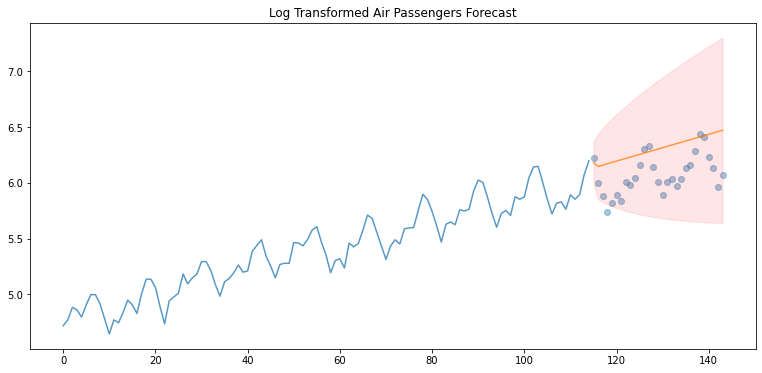

In [28]:
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다. train과 test data를 축(axis)으로 만듬
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 위그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성.
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test, 
            alpha=0.4, marker='o')  # 기존 test data는 scatter. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성.
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='r') #  분포에 해당하는 구간을 붉은 음영으로 채움.
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 위 4가지 plot을 하나로 시각화.

### 4가지 plot을 하나로 시각화한 위 그래프 분석

- 위 주황색 선은 예측값 : Arima(0, 1, 2)이 점 추정한 선.현재 추세를 잘 반영한거라고 함.


- 점점이는 모델을 통해서 나온게 아닌 원래 가지고 있던 y값. 신뢰구간 95%에 위치하고 있어  Arima(0, 1, 2)모델은 'Log Transformed Air Passengers'를 비교적 잘 예측한다고 본다.

### ⑦ ARCH 모델 실습 

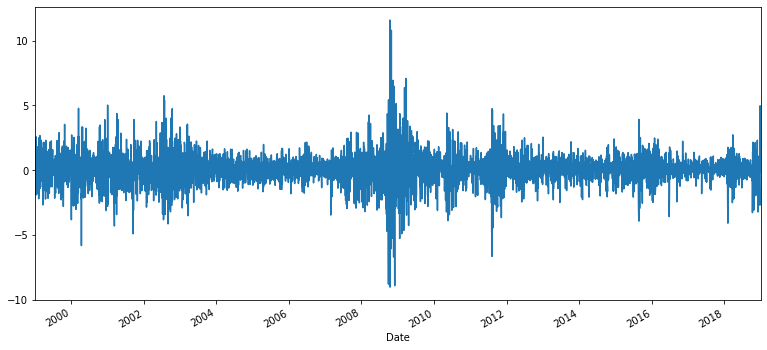

In [29]:
# ⑦-1 : 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리.
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옴.

# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인
st = dt.datetime(2002, 1, 1) #start date
en = dt.datetime(2022, 1, 1) #end date
data = arch.data.sp500.load() #s&p 500 데이터 불러오기
market = data["Adj Close"] #종가만 활용
returns = 100 * market.pct_change().dropna() #return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기 
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 합니다. Q 뭔 소린지 ?
plt.show()

### 위 그래프가  Conditional Heteroskedasticity조건부 이분산성을  잘 나타낸다고 함.

조건부 이분산성 -

- 독립변수와 오차항이 상관관계가 있는 경우.

- ARCH 모형의 파생형 중 하나로 어떤 시계열의 평균은 예측하지 못해도 분산은 예측할 수 있는 경우라 할 수 있다. 
  금융시장에서 각종 가격변수들을 예측할 때 널리 사용. FRM 등의 시험에도 출제되는 매우 범용적인 부분.


In [30]:
# ⑦-3 : ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) #return, 즉 수익율을 arch모델에 적합
res = am.fit(update_freq=5)

# ⑦-4 : 지표를 통한 결과 확인
print(res.summary())
#다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
#아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 95%에서 이들이 유의미함을 도출

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Sun, Jan 08 2023   Df Residuals:                     5029
Time:         

###  ARCH 모델 적용분석

-  AIC와 BIC는 낮을수록 접합도가 높은것, 13881은 매우 수치가 커서 접합도가 낮은거?

-  Volatility Model을 중심으로 봐야한다. P값은 4.105e-15승은 매우 낮은 수치. alpha값은 ARCH 모델을 통해 얻는 파라미터, beta값은 alpha값을 제외한 파라미터.

- Arch 1,1에서 각 파라미터들이 유의미하다. 신뢰도 99% Arch 1,1의 확률과정을 따른다 Q 도대체 무슨 말인지?... 위 분석에 어디에 99%가 있는지? P>|t|, pt등을 검색을 해봐도 나오는게 없다.


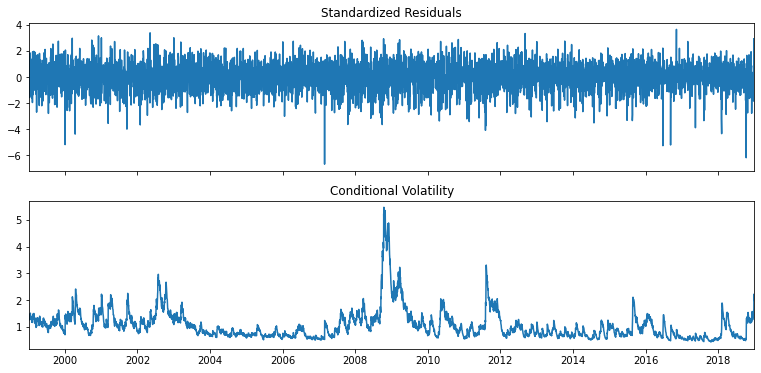

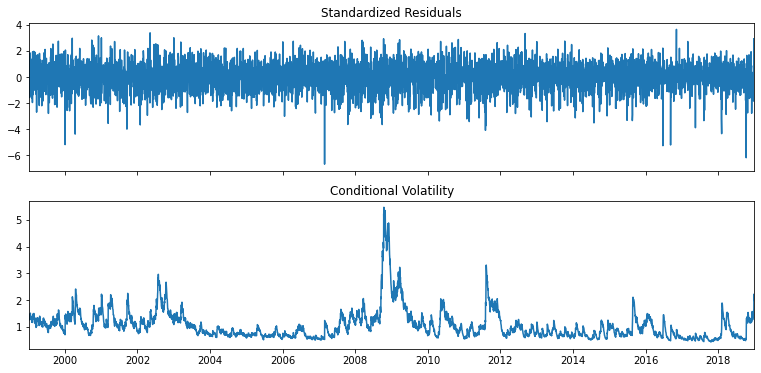

In [31]:
# ⑦-5 : 시각화를 통한 결과값 확인
res.plot()

모델 적합 후 남은 잔차(Residual)와 포착한 조건부 변동성(conditional volatility)을 시각적으로 확인

- Standardized Residuals 그래프가 (노드강의 11ㅣ40) 뚜렷한 조건부 이분산성없고 비교적 모델 적합이 잘됐다 Q 무조건부 이분산성있는 그래프는 어떻게 생겼길래 -> 찾아보니 변동폭이 크네. 변동폭이 일정하면 적합이 잘된거 ?
 https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=yonxman&logNo=220950614789

### Refference

https://heytech.tistory.com/318

https://story-opinion.tistory.com/25

https://otexts.com/fppkr/seasonal-arima.html

https://namu.wiki/w/GARCH

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=yonxman&logNo=220950614789

## 회고 

-  PACF상  n = 12가 유의미한 상관관계가 나타나서 왜 계절성 때문인지 모르겠다. 찾아보니  AR이나 MA 모델의 계절성 부분은 PACF와 ACF의 계절성 시차에서 볼 수 있다고 하고... 생각 좀 해보자 

- Log Transformed Air Passengers Forecast 그래프, 4가지 plot을 하나로 시각화한것에서 '점점이들이 신뢰구간 95%에 위치하고 있다'고 했는데 95%라고 표시된것이 없는데..

- ARCH 모델 실습의 첫 그래프가  Conditional Heteroskedasticity조건부 이분산성을 잘 나타낸다고 하는데 강의를 꼼꼼히 들어봐도, 검색을 해보아도 위에 메모한 내용이 전부인데 왜 조건부 이분산성을 잘 나타내는지 모르겠다. 구글검색에 해당 내용이 잘 나오지 않음. 

- ARCH 모델 적용분석에서(노드강의 11분) 아무리 반복해서 들어봐도 'Arch 1,1에서 각 파라미터들이 유의미하다'는 근거 선명치 못하고 참 ~ 강의내용 깔끔치 못하네. 
